# Classifiers - busy vs relaxed - no TFv1
Exploring different classifiers with different autoencoders. No contractive autoencoder because it needs TFv1 compatibility.

#### Table of contents:  

autoencoders:  
[Undercomplete Autoencoder](#Undercomplete-Autoencoder)  
[Sparse Autoencoder](#Sparse-Autoencoder)  
[Deep Autoencoder](#Deep-Autoencoder)  

classifiers:  
[Simple dense classifier](#Simple-dense-classifier)  
[LSTM-based classifier](#LSTM-based-classifier)  
[kNN](#kNN)  
[SVC](#SVC)  
[Random Forest](#Random-Forest)  
[XGBoost](#XGBoost)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import pandas
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, Nadam
import tensorflow.keras.backend as K
tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy']

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import json
from datetime import datetime
import warnings
import matplotlib.pyplot as plt

In [2]:
import random

random.seed(1)
np.random.seed(4)
tf.random.set_seed(2)

In [3]:
# Start the notebook in the terminal with "PYTHONHASHSEED=0 jupyter notebook" 
# or in anaconda "set PYTHONHASHSEED=0" then start jupyter notebook
import os
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 before starting the Jupyter server to get reproducible results.")

This is modfied original author's code for reading data:

In [4]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [5]:
def get_busy_vs_relax_timeframes_br_hb(path, ident, seconds, checkIfValid=True):
    """Returns raw data from either 'on task' or 'relax' time frames and their class (0 or 1)."""
    
    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))
        
        ### task versus relax (1 sample each)
        dataextract = dataextractor.DataExtractor(data[0][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  data[1][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  samp_rate)

        dataextract_relax = dataextractor.DataExtractor(data[0][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        data[1][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        samp_rate)

        try:

            # get extracted features for breathing
            tmpBR_busy = dataextract.extract_from_breathing_time(dataextract.t[-samp_rate*seconds:],
                                                                 dataextract.y[-samp_rate*seconds:])
            tmpBR_relax = dataextract_relax.extract_from_breathing_time(dataextract_relax.t[-samp_rate*seconds:],
                                                                 dataextract_relax.y[-samp_rate*seconds:])
            #get extracted features for heartbeat
            tmpHB_busy = dataextract.extract_from_heartbeat_time(dataextract.t[-samp_rate*seconds:],
                                                                 dataextract.y[-samp_rate*seconds:])
            tmpHB_relax = dataextract.extract_from_heartbeat_time(dataextract_relax.t[-samp_rate*seconds:],
                                                                 dataextract_relax.y[-samp_rate*seconds:])
            
            if checkIfValid and not(tmpBR_busy['br_ok'][0] and tmpBR_relax['br_ok'][0]):# and tmpHB_busy['hr_ok'][0] and tmpHB_relax['hr_ok'][0]):
                # don't add this to the data that will be returned
                # by going to the next iteration
                continue

            tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
            tmp_tasks_y = np.vstack((tasks_y, 1))
            tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
            tmp_tasks_y = np.vstack((tmp_tasks_y, 0))

            # put busy frames then relaxed frames under the previous frames
            tmp_breathing = np.vstack((tmp_breathing, tmpBR_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            tmp_breathing = np.vstack((tmp_breathing, tmpBR_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

            tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

        except ValueError:
#             print(ident)  # ignore short windows
            continue

        # put busy frames then relaxed frames under the previous frames
        tasks_data = np.vstack((tasks_data, dataextract.y[-samp_rate * seconds:]))
        tasks_y = np.vstack((tasks_y, 1))
        tasks_data = np.vstack((tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
        tasks_y = np.vstack((tasks_y, 0))

        breathing = np.vstack((breathing, tmp_breathing))

        heartbeat = np.vstack((heartbeat, tmp_heartbeat))

        tasks_data = np.unwrap(tasks_data)
        
    return tasks_data, tasks_y, breathing, heartbeat

In [6]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes

            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

In [7]:
# Accs is a dictionary which holds 1d arrays of accuracies in each key
# except the key 'test id' which holds strings of the id which yielded the coresponding accuracies
def print_accs_stats(accs):
    
    printDict = {}
    # loop over each key
    for key in accs:
    
        if (key == 'test id'):
            # skip calculating ids
            continue
        printDict[key] = {}
        tmpDict = printDict[key]
        # calculate and print some statistics
        tmpDict['min'] = np.min(accs[key])
        tmpDict['max'] = np.max(accs[key])
        tmpDict['mean'] = np.mean(accs[key])
        tmpDict['median'] = np.median(accs[key])
    
    print(pandas.DataFrame.from_dict(printDict).to_string())

In [8]:
def clear_session_and_set_seeds():
    # clear session and set seeds again
    K.clear_session()
    random.seed(1)
    np.random.seed(4)
    tf.random.set_seed(2)

## Prepare data

Initialize variables:

In [9]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

In [10]:
# Holds all the data so it doesnt have to be read from file each time
data_dict = {}

Fill the data dictionary:

In [11]:
for ident in idents:
    
    # initialize ident in 
    data_dict[ident] = {}
    tmpDataDict = data_dict[ident]
    
    # read data
    phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, [ident], seconds)
    
    if (y.shape[0] <= 0):
        idents.remove(ident)
        print(ident)
        continue
    
    # load data into dictionary
    tmpDataDict['phase'] = phase
    tmpDataDict['y'] = y
    tmpDataDict['breathing'] = breathing
    tmpDataDict['heartbeat'] = heartbeat
    tmpDataDict['combined'] = combined

In [12]:
# load all phase data to use for training autoencoders
phase_all_train = get_data_from_idents_br_hb(path, idents[:-4], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_train = MinMaxScaler().fit_transform(phase_all_train.T).T

# load all validation phase data to use for training autoencoders
phase_all_valid = get_data_from_idents_br_hb(path, idents[-4:], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_valid = MinMaxScaler().fit_transform(phase_all_valid.T).T

## Autoencoders  
Train autoencoders to save their encoded representations in the data dictionary:

In [13]:
# AE Training params
batch_size = 128
epochs = 1000
encoding_dim = 30
ae_encoded_shape = np.empty((0,encoding_dim))

In [14]:
def compare_plot_n(data1, data2, data3, plot_n=5):
    
    #plot data1 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data1[i])

    #plot data2 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data2[i])
        
    #plot data3 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data3[i])

#### Undercomplete Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [15]:
def undercomplete_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.125, name="dropout", seed=42)(input_data)
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu', name="encoded")(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    autoencoder = Model(input_data, decoded)
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [16]:
clear_session_and_set_seeds()
uc_ae, uc_enc = undercomplete_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
uc_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot signal, reconstruction and encoded representation:

<Figure size 432x288 with 0 Axes>

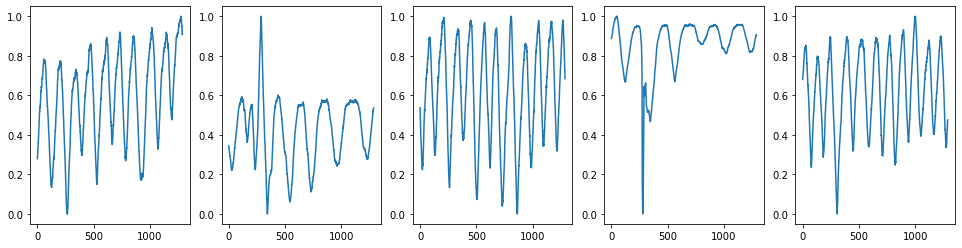

<Figure size 432x288 with 0 Axes>

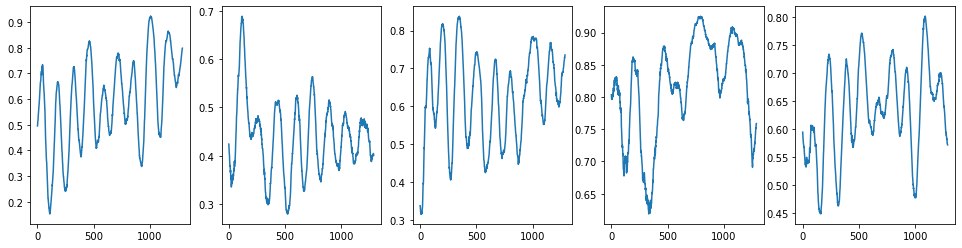

<Figure size 432x288 with 0 Axes>

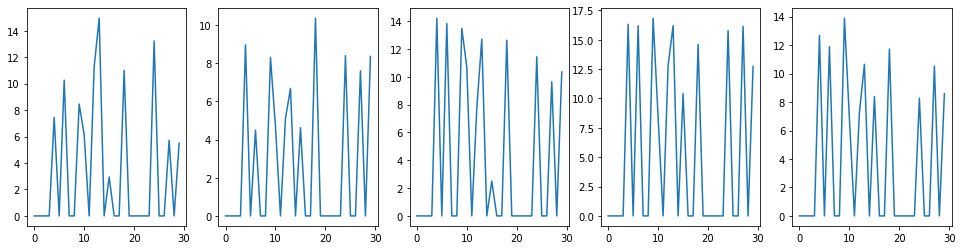

In [17]:
data2 = uc_ae.predict(phase_all_valid)
data3 = uc_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, data3)

Store the encoded representations in the data dictionary:

In [18]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
#     print(ident)
    uc_data = uc_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['undercomplete_encoded'] = uc_data

#### Sparse Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [19]:
def sparse_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.125, name="dropout", seed=42) (input_data)
    # "encoded" is the encoded representation of the input
    # add a sparsity constraint
    encoded = Dense(encoding_dim, activation='relu', name="encoded",
                    activity_regularizer=regularizers.l1(10e-5))(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_data, decoded, name="sparse_ae")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [20]:
clear_session_and_set_seeds()
sp_ae, sp_enc = sparse_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
sp_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot signal, reconstruction and encoded representation:

<Figure size 432x288 with 0 Axes>

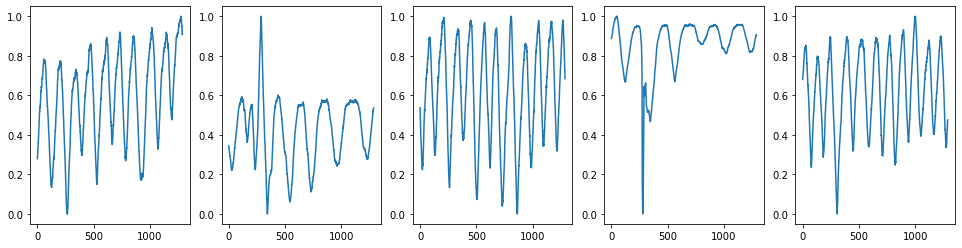

<Figure size 432x288 with 0 Axes>

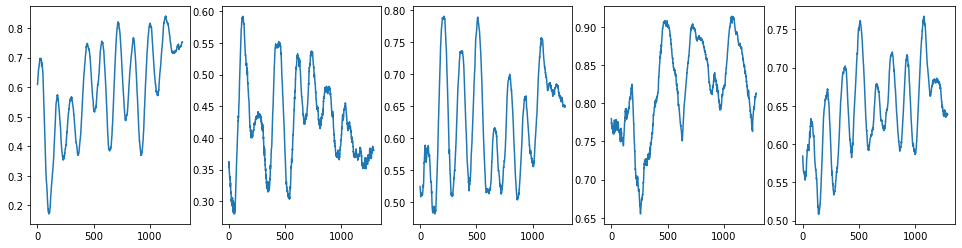

<Figure size 432x288 with 0 Axes>

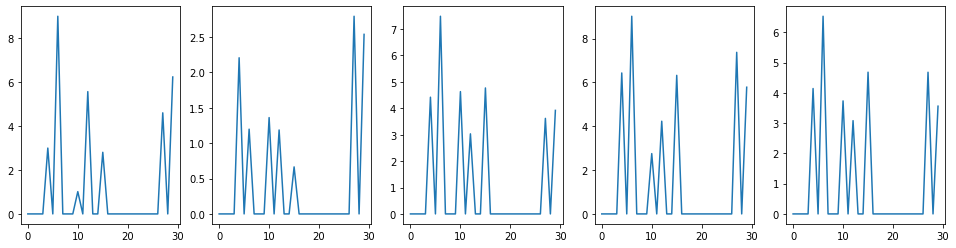

In [21]:
data2 = sp_ae.predict(phase_all_valid)
data3 = sp_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, data3)

Store the encoded representations in the data dictionary:

In [22]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    sp_data = sp_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['sparse_encoded'] = sp_data

#### Deep Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [23]:
def deep_ae(x, enc_layers=[512,128], encoding_dim=64, dec_layers=[128,512], encoded_as_model=False):
    # From https://www.tensorflow.org/guide/keras/functional#use_the_same_graph_of_layers_to_define_multiple_models
    input_data = keras.Input(shape=x[0].shape, name="normalized_signal")
    model = Dropout(0.125, name="dropout", autocast=False, seed=42)(input_data)
    for i in enumerate(enc_layers):
        model = Dense(i[1], activation="relu", name="dense_enc_" + str(i[0]+1))(model)
    encoded_output = Dense(encoding_dim, activation="relu", name="encoded_signal")(model)

    encoded = encoded_output

    model = layers.Dense(dec_layers[0], activation="sigmoid", name="dense_dec_1")(encoded_output)
    for i in enumerate(dec_layers[1:]):
        model = Dense(i[1], activation="sigmoid", name="dense_dec_" + str(i[0]+2))(model)
    decoded_output = Dense(x[0].shape[0], activation="sigmoid", name="reconstructed_signal")(model)
    
    autoencoder = Model(input_data, decoded_output, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)

    return autoencoder, encoded

Train autoencoder on data:

In [24]:
clear_session_and_set_seeds()
de_ae, de_enc = deep_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
de_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot signal, reconstruction and encoded representation:

<Figure size 432x288 with 0 Axes>

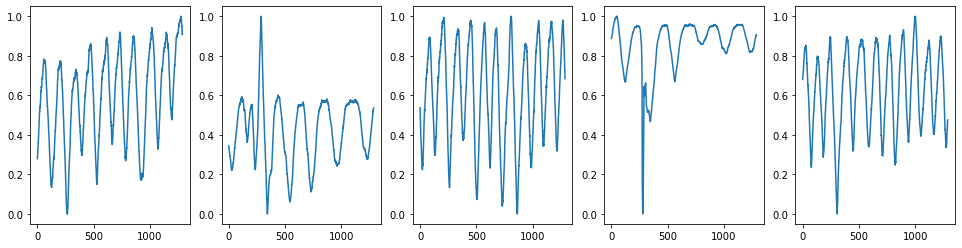

<Figure size 432x288 with 0 Axes>

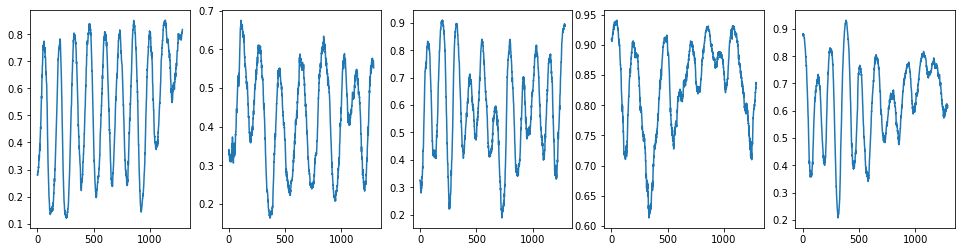

<Figure size 432x288 with 0 Axes>

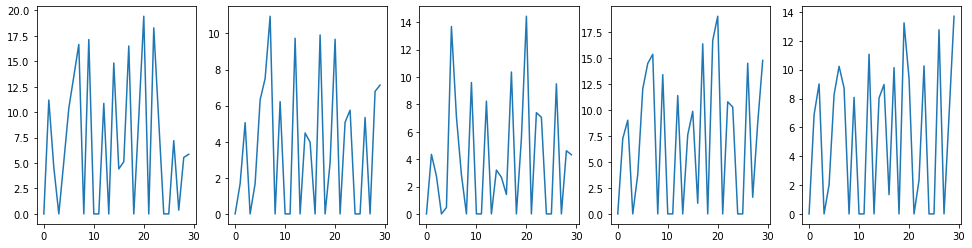

In [25]:
data2 = de_ae.predict(phase_all_valid)
data3 = de_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, data3)

Store the encoded representations in the data dictionary:

In [26]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    de_data = de_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['deep_encoded'] = de_data

Helper function to get data from the dictionary:

In [27]:
def get_ident_data_from_dict(idents, data_dict):
    
    # Initialize data variables
    y = y_shape.copy()
    phase = phase_shape.copy()
    breathing = breathing_shape.copy()
    heartbeat = heartbeat_shape.copy()
    combined = combined_shape.copy()
    undercomplete_encoded = ae_encoded_shape.copy()
    sparse_encoded = ae_encoded_shape.copy()
    deep_encoded = ae_encoded_shape.copy()
    
    # Stack data form each ident into the variables
    for tmp_id in idents:
        y = np.vstack((y, data_dict[tmp_id]['y']))
        phase = np.vstack((phase, data_dict[tmp_id]['phase']))
        breathing = np.vstack((breathing, data_dict[tmp_id]['breathing']))
        heartbeat = np.vstack((heartbeat, data_dict[tmp_id]['heartbeat']))
        combined = np.vstack((combined, data_dict[tmp_id]['combined']))
        undercomplete_encoded = np.vstack((undercomplete_encoded, data_dict[tmp_id]['undercomplete_encoded']))
        sparse_encoded = np.vstack((sparse_encoded, data_dict[tmp_id]['sparse_encoded']))
        deep_encoded = np.vstack((deep_encoded, data_dict[tmp_id]['deep_encoded']))
    
    return y, phase, breathing, heartbeat, combined, undercomplete_encoded, sparse_encoded, deep_encoded

## Classifiers

#### Helper loop function definition  
A function that loops over all the data and calls the classifiers with it then stores the returned accuracies.

In [28]:
def helper_loop(classifier_function_train, idents, n=5, num_loops_to_average_over=1, should_scale_data=True):
    #returns a dictionary with accuracies

    # set the variables in the dictionary
    accs = {}
    accs['phase'] = []
    accs['breathing'] = []
    accs['heartbeat'] = []
    accs['combined br hb'] = []
    accs['undercomplete'] = []
    accs['sparse'] = []
    accs['deep'] = []
    accs['test id'] = []
    start_time = datetime.now()

    # leave out person out validation
    for i in range(n):
        
        # print current iteration and time elapsed from start
        print("iteration:", i+1, "of", n, "; time elapsed:", datetime.now()-start_time)

        ## ----- Data preparation:
        validation_idents = [idents[i]]
        test_idents = [idents[i-1]]
        
        train_idents = []
        for ident in idents:
            if (ident not in test_idents) and (ident not in validation_idents):
                train_idents.append(ident)

        # save test id to see which id yielded which accuracies
        accs['test id'].append(test_idents[0])

        # Load train data
        train_data = get_ident_data_from_dict(train_idents, data_dict)
        y_train = train_data[0]
        
        # Load validation data
        valid_data = get_ident_data_from_dict(validation_idents, data_dict)
        y_valid = valid_data[0]

        # Load test data
        test_data = get_ident_data_from_dict(test_idents, data_dict)
        y_test = test_data[0]
        
        data_names_by_index = ['y', 'phase', 'breathing', 'heartbeat',
                                   'combined br hb', 'undercomplete', 'sparse', 'deep']

        # Loop over all data that will be used for classification and send it to the classifier
        # index 0 is y so we skip it
        for index in range(1, len(test_data)):
            clear_session_and_set_seeds()
            train_x = train_data[index]
            valid_x = valid_data[index]
            test_x = test_data[index]
            
            # Scale data
            if should_scale_data:
                # Scale with standard scaler
                sscaler = StandardScaler()
                sscaler.fit(train_x)
                train_x = sscaler.transform(train_x)

                # Scale valid and test with train's scaler
                valid_x = sscaler.transform(valid_x)
                test_x = sscaler.transform(test_x)
            
            # Initialize variables
            tmp_acc = []
            data_name = data_names_by_index[index]
            
            for tmp_index in range(num_loops_to_average_over):
                curr_acc = classifier_function_train(train_x, y_train, valid_x, y_valid, test_x, y_test, data_name)
                tmp_acc.append(curr_acc)
            
            # Store accuracy
            curr_acc = np.mean(tmp_acc)
            accs[data_name].append(curr_acc)
        

    # Print total time required to run this
    end_time = datetime.now()
    elapsed_time = end_time - start_time
    print("Completed!", "Time elapsed:", elapsed_time)
    
    return accs

#### Simple dense classifier

Define the classifier:

In [29]:
params_dense_phase = {
    'dropout': 0.4,
    'hidden_size': 26,
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': Adam,
    'batch_size': 128,
    'learning_rate': 0.001,
    'epochs': 300
}

In [30]:
params_dense_br_hb = {
    'dropout': 0.05,
    'hidden_size': 24,
    'activation': 'sigmoid',
    'loss': 'poisson',
    'optimizer': Nadam,
    'learning_rate': 0.05,
    'batch_size': 128,
    'epochs': 100
}

In [31]:
params_dense_ae_enc = {
    'dropout': 0.05,
    'hidden_size': 34,
    'activation': 'relu',
    'loss': 'binary_crossentropy',
    'optimizer': Adam,
    'learning_rate': 0.005,
    'batch_size': 106,
    'epochs': 200
}

In [32]:
def dense_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_dense_br_hb
    if (data_name == 'phase'):
        params = params_dense_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_dense_ae_enc
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['hidden_size']))
    model.add(Activation(params['activation']))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=metrics)
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, x_train, y_train, params['batch_size'], params['epochs'],
                                           x_valid, y_valid, x_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [33]:
accs = helper_loop(dense_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:22.123667
iteration: 3 of 23 ; time elapsed: 0:00:43.698796
iteration: 4 of 23 ; time elapsed: 0:01:06.072564
iteration: 5 of 23 ; time elapsed: 0:01:28.393856
iteration: 6 of 23 ; time elapsed: 0:01:51.490053
iteration: 7 of 23 ; time elapsed: 0:02:13.931533
iteration: 8 of 23 ; time elapsed: 0:02:36.069415
iteration: 9 of 23 ; time elapsed: 0:02:58.350395
iteration: 10 of 23 ; time elapsed: 0:03:20.667872
iteration: 11 of 23 ; time elapsed: 0:03:42.752588
iteration: 12 of 23 ; time elapsed: 0:04:04.919027
iteration: 13 of 23 ; time elapsed: 0:04:27.401850
iteration: 14 of 23 ; time elapsed: 0:04:49.881703
iteration: 15 of 23 ; time elapsed: 0:05:12.836283
iteration: 16 of 23 ; time elapsed: 0:05:34.563110
iteration: 17 of 23 ; time elapsed: 0:05:56.794206
iteration: 18 of 23 ; time elapsed: 0:06:20.825900
iteration: 19 of 23 ; time elapsed: 0:06:43.628869
iteration: 20 of 23 ; time elapsed: 0:07:06.172

In [34]:
accuracies['simple_dense'] = accs

In [35]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,1.000000,0.500000,0.500000,1.000000,0.500000,0.500000,0.500000,62i9y
1,0.833333,0.666667,0.333333,0.611111,0.833333,0.777778,0.666667,2gu87
2,0.800000,0.800000,0.550000,0.750000,0.900000,0.800000,0.550000,iz2ps
3,0.541667,0.875000,0.541667,0.708333,0.500000,0.458333,0.416667,1mpau
4,0.583333,0.833333,0.500000,0.583333,0.666667,0.500000,0.500000,7dwjy
5,0.785714,0.714286,0.428571,0.785714,0.642857,0.642857,0.714286,7swyk
6,0.750000,0.666667,0.583333,0.500000,0.750000,0.666667,0.583333,94mnx
7,0.500000,0.500000,0.500000,0.875000,0.625000,0.750000,0.625000,bd47a
8,0.636364,0.863636,0.681818,0.772727,0.545455,0.500000,0.500000,c24ur
9,0.500000,0.750000,1.000000,0.875000,0.625000,0.625000,0.750000,ctsax


In [36]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.375000   0.375000   0.333333        0.350000       0.444444  0.375000  0.375000
max     1.000000   0.875000   1.000000        1.000000       0.900000  0.875000  0.833333
mean    0.653965   0.691264   0.539787        0.684118       0.625811  0.606258  0.616935
median  0.625000   0.714286   0.500000        0.687500       0.625000  0.625000  0.625000


#### LSTM-based classifier  
based on the original author's code

In [37]:
params_lstm_phase = {
    'kernel_size': 4,
    'filters': 32,
    'strides': 2,
    'pool_size': 4,
    'dropout': 0.1,
    'lstm_output_size': 22,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': Nadam,
    'learning_rate': 0.005,
    'batch_size': 168,
    'epochs': 200
}

In [38]:
params_lstm_br_hb = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 1,
    'dropout': 0.01,
    'lstm_output_size': 64,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'poisson',
    'optimizer': Nadam,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 100
}

In [39]:
params_lstm_ae_enc = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 2,
    'dropout': 0.01,
    'lstm_output_size': 32,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'poisson',
    'optimizer': Nadam,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 100
}

In [40]:
def LSTM_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_lstm_br_hb
    if (data_name == 'phase'):
        params = params_lstm_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_lstm_ae_enc
    
    # Reshape data to fit some layers
    xt_train = x_train.reshape(-1, x_train[0].shape[0], 1)
    xt_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
    xt_test = x_test.reshape(-1, x_test[0].shape[0], 1)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))

    model.add(MaxPooling1D(pool_size=params['pool_size']))
    
    if (data_name == 'phase'):
        model.add(Conv1D(params['filters'],
                         params['kernel_size'],
                         padding='valid',
                         activation=params['activation'],
                         strides=params['strides']))
        model.add(MaxPooling1D(pool_size=params['pool_size']))

    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['lstm_output_size']))
    model.add(Dense(1))
    model.add(Activation(params['last_activation']))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=['acc'])
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, xt_train, y_train, params['batch_size'], params['epochs'],
                                           xt_valid, y_valid, xt_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [41]:
accs = helper_loop(LSTM_train, idents, n=n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:54.100497
iteration: 3 of 23 ; time elapsed: 0:01:46.831669
iteration: 4 of 23 ; time elapsed: 0:02:39.431181
iteration: 5 of 23 ; time elapsed: 0:03:30.062460
iteration: 6 of 23 ; time elapsed: 0:04:24.850025
iteration: 7 of 23 ; time elapsed: 0:05:17.977518
iteration: 8 of 23 ; time elapsed: 0:06:11.200167
iteration: 9 of 23 ; time elapsed: 0:07:06.393226
iteration: 10 of 23 ; time elapsed: 0:08:00.949211
iteration: 11 of 23 ; time elapsed: 0:08:57.009799
iteration: 12 of 23 ; time elapsed: 0:09:50.702214
iteration: 13 of 23 ; time elapsed: 0:10:45.675572
iteration: 14 of 23 ; time elapsed: 0:11:38.522318
iteration: 15 of 23 ; time elapsed: 0:12:32.188016
iteration: 16 of 23 ; time elapsed: 0:13:26.299176
iteration: 17 of 23 ; time elapsed: 0:14:19.470051
iteration: 18 of 23 ; time elapsed: 0:15:16.444878
iteration: 19 of 23 ; time elapsed: 0:16:13.379113
iteration: 20 of 23 ; time elapsed: 0:17:07.455

In [42]:
accuracies['LSTM'] = accs

In [43]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,1.000000,1.000000,0.500000,1.000000,0.500000,0.500000,0.500000,62i9y
1,0.777778,0.722222,0.444444,0.777778,0.666667,0.611111,0.500000,2gu87
2,0.900000,0.700000,0.450000,0.700000,0.700000,0.450000,0.500000,iz2ps
3,0.625000,0.875000,0.500000,0.791667,0.416667,0.458333,0.333333,1mpau
4,0.666667,0.666667,0.750000,0.583333,0.333333,0.333333,0.666667,7dwjy
5,0.857143,0.928571,0.357143,0.857143,0.500000,0.500000,0.714286,7swyk
6,0.750000,0.666667,0.333333,0.666667,0.666667,0.500000,0.666667,94mnx
7,0.875000,0.625000,0.375000,0.750000,0.875000,0.750000,0.625000,bd47a
8,0.818182,0.818182,0.727273,0.772727,0.500000,0.500000,0.500000,c24ur
9,0.875000,1.000000,0.500000,0.625000,0.625000,0.500000,0.625000,ctsax


In [44]:
# print some statistics for each method
print_accs_stats(accs)

          phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.50000   0.437500   0.333333        0.375000       0.333333  0.333333  0.333333
max     1.00000   1.000000   0.750000        1.000000       0.875000  0.750000  0.750000
mean    0.71846   0.724836   0.522172        0.697689       0.560187  0.553972  0.557570
median  0.75000   0.700000   0.500000        0.666667       0.538462  0.533333  0.583333


#### kNN

In [45]:
params_knn_phase = {
    'n_neighbors': 5,
    'metric': 'cosine'
}

In [46]:
params_knn_br_hb = {
    'n_neighbors': 15,
    'metric': 'manhattan'
}

In [47]:
params_knn_ae_enc = {
    'n_neighbors': 15,
    'metric': 'cosine'
}

In [48]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_classifier(params):
    model = KNeighborsClassifier(n_neighbors=params['n_neighbors'], metric=params['metric'])
    return model

In [49]:
def KNN_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_knn_br_hb
    if (data_name == 'phase'):
        params = params_knn_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_knn_ae_enc
    
    model = KNN_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [50]:
accs = helper_loop(KNN_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.092990
iteration: 3 of 23 ; time elapsed: 0:00:00.145876
iteration: 4 of 23 ; time elapsed: 0:00:00.194717
iteration: 5 of 23 ; time elapsed: 0:00:00.248573
iteration: 6 of 23 ; time elapsed: 0:00:00.296446
iteration: 7 of 23 ; time elapsed: 0:00:00.346313
iteration: 8 of 23 ; time elapsed: 0:00:00.396181
iteration: 9 of 23 ; time elapsed: 0:00:00.444054
iteration: 10 of 23 ; time elapsed: 0:00:00.493921
iteration: 11 of 23 ; time elapsed: 0:00:00.539797
iteration: 12 of 23 ; time elapsed: 0:00:00.586672
iteration: 13 of 23 ; time elapsed: 0:00:00.635541
iteration: 14 of 23 ; time elapsed: 0:00:00.684439
iteration: 15 of 23 ; time elapsed: 0:00:00.738266
iteration: 16 of 23 ; time elapsed: 0:00:00.783146
iteration: 17 of 23 ; time elapsed: 0:00:00.835514
iteration: 18 of 23 ; time elapsed: 0:00:00.884383
iteration: 19 of 23 ; time elapsed: 0:00:00.930260
iteration: 20 of 23 ; time elapsed: 0:00:00.977

In [51]:
accuracies['kNN'] = accs

In [52]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.500000,1.000000,1.000000,0.500000,1.000000,0.500000,1.000000,62i9y
1,0.833333,0.611111,0.333333,0.666667,0.500000,0.444444,0.833333,2gu87
2,0.750000,0.850000,0.650000,0.900000,0.650000,0.650000,0.600000,iz2ps
3,0.541667,0.583333,0.791667,0.583333,0.416667,0.458333,0.541667,1mpau
4,0.583333,0.750000,0.833333,0.583333,0.500000,0.500000,0.416667,7dwjy
5,0.857143,0.857143,0.500000,0.785714,0.642857,0.642857,0.571429,7swyk
6,0.500000,0.666667,0.416667,0.750000,0.666667,0.583333,0.583333,94mnx
7,0.500000,0.625000,0.625000,0.875000,0.625000,0.625000,0.375000,bd47a
8,0.681818,0.954545,0.590909,0.681818,0.727273,0.590909,0.500000,c24ur
9,0.750000,1.000000,0.750000,1.000000,0.750000,0.750000,0.750000,ctsax


In [53]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.500000   0.375000   0.300000        0.437500       0.350000  0.444444  0.350000
max     0.923077   1.000000   1.000000        1.000000       1.000000  0.750000  1.000000
mean    0.673168   0.747062   0.574080        0.705807       0.596007  0.575023  0.603129
median  0.681818   0.750000   0.583333        0.750000       0.583333  0.583333  0.583333


####  SVC

In [54]:
params_svc_phase = {
    'C': 10,
    'kernel': 'rbf',
    'gamma': 'scale'
}

In [55]:
params_svc_br_hb = {
    'C': 2,
    'kernel': 'rbf',
    'gamma': 'auto'
}

In [56]:
params_svc_ae_enc = {
    'C': 3,
    'kernel': 'rbf',
    'gamma': 'auto'
}

In [57]:
from sklearn.svm import SVC

def SVC_classifier(params):
    model = SVC(random_state=42, C=params['C'], kernel=params['kernel'], gamma=params['gamma'])
    return model

In [58]:
def SVC_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_svc_br_hb
    if (data_name == 'phase'):
        params = params_svc_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_svc_ae_enc
    
    model = SVC_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [59]:
accs = helper_loop(SVC_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.224619
iteration: 3 of 23 ; time elapsed: 0:00:00.406142
iteration: 4 of 23 ; time elapsed: 0:00:00.583631
iteration: 5 of 23 ; time elapsed: 0:00:00.772154
iteration: 6 of 23 ; time elapsed: 0:00:00.968629
iteration: 7 of 23 ; time elapsed: 0:00:01.169129
iteration: 8 of 23 ; time elapsed: 0:00:01.369663
iteration: 9 of 23 ; time elapsed: 0:00:01.561559
iteration: 10 of 23 ; time elapsed: 0:00:01.764264
iteration: 11 of 23 ; time elapsed: 0:00:01.974730
iteration: 12 of 23 ; time elapsed: 0:00:02.168215
iteration: 13 of 23 ; time elapsed: 0:00:02.357705
iteration: 14 of 23 ; time elapsed: 0:00:02.546175
iteration: 15 of 23 ; time elapsed: 0:00:02.733671
iteration: 16 of 23 ; time elapsed: 0:00:02.913855
iteration: 17 of 23 ; time elapsed: 0:00:03.104351
iteration: 18 of 23 ; time elapsed: 0:00:03.306855
iteration: 19 of 23 ; time elapsed: 0:00:03.497856
iteration: 20 of 23 ; time elapsed: 0:00:03.682

In [60]:
accuracies['SVC'] = accs

In [61]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.500000,0.500000,1.000000,0.500000,0.500000,0.500000,0.500000,62i9y
1,0.888889,0.722222,0.388889,0.722222,0.611111,0.611111,0.611111,2gu87
2,0.700000,0.800000,0.650000,0.850000,0.700000,0.750000,0.550000,iz2ps
3,0.583333,0.791667,0.708333,0.583333,0.458333,0.416667,0.500000,1mpau
4,0.583333,0.750000,0.583333,0.583333,0.583333,0.583333,0.583333,7dwjy
5,0.785714,0.714286,0.500000,0.928571,0.571429,0.500000,0.571429,7swyk
6,0.833333,0.500000,0.500000,0.416667,0.666667,0.666667,0.666667,94mnx
7,0.875000,0.625000,0.500000,0.750000,0.875000,0.875000,0.750000,bd47a
8,0.545455,0.863636,0.636364,0.772727,0.500000,0.500000,0.500000,c24ur
9,0.750000,0.875000,0.875000,0.875000,0.750000,0.625000,0.625000,ctsax


In [62]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.444444   0.375000   0.250000        0.416667       0.375000  0.416667  0.444444
max     0.888889   1.000000   1.000000        0.928571       0.875000  0.875000  0.750000
mean    0.666182   0.698167   0.569999        0.675716       0.571770  0.577722  0.602469
median  0.625000   0.714286   0.500000        0.666667       0.571429  0.562500  0.583333


#### Random Forest

In [63]:
params_rf_phase = {
    'n_estimators': 180,
    'max_depth': 50,
    'min_samples_split': 4,
    'min_samples_leaf': 1,
    'oob_score': False,
    'ccp_alpha': 0.001
}

In [64]:
params_rf_br_hb = {
    'n_estimators': 180,
    'max_depth': None,
    'min_samples_split': 3,
    'min_samples_leaf': 3,
    'oob_score': False,
    'ccp_alpha': 0.005
}

In [65]:
params_rf_ae_enc = {
    'n_estimators': 130,
    'max_depth': 100,
    'min_samples_split': 5,
    'min_samples_leaf': 5,
    'oob_score': True,
    'ccp_alpha': 0.005
}

In [66]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier(params):
    model = RandomForestClassifier(random_state=42,
                                   n_estimators = params['n_estimators'],
                                   criterion = 'entropy',
                                   max_depth = params['max_depth'],
                                   min_samples_split = params['min_samples_split'],
                                   min_samples_leaf = params['min_samples_leaf'],
                                   oob_score = params['oob_score'],
                                   ccp_alpha = params['ccp_alpha'],
                                   max_features = 'log2',
                                   bootstrap = True)
    return model

In [67]:
def random_forest_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_rf_br_hb
    if (data_name == 'phase'):
        params = params_rf_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_rf_ae_enc
    
    model = random_forest_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [68]:
accs = helper_loop(random_forest_train, idents, n, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:02.293568
iteration: 3 of 23 ; time elapsed: 0:00:04.453323
iteration: 4 of 23 ; time elapsed: 0:00:06.479286
iteration: 5 of 23 ; time elapsed: 0:00:08.590510
iteration: 6 of 23 ; time elapsed: 0:00:10.785165
iteration: 7 of 23 ; time elapsed: 0:00:13.176374
iteration: 8 of 23 ; time elapsed: 0:00:15.755883
iteration: 9 of 23 ; time elapsed: 0:00:17.885790
iteration: 10 of 23 ; time elapsed: 0:00:19.978107
iteration: 11 of 23 ; time elapsed: 0:00:22.152595
iteration: 12 of 23 ; time elapsed: 0:00:24.284908
iteration: 13 of 23 ; time elapsed: 0:00:26.373722
iteration: 14 of 23 ; time elapsed: 0:00:28.525962
iteration: 15 of 23 ; time elapsed: 0:00:30.734648
iteration: 16 of 23 ; time elapsed: 0:00:32.775551
iteration: 17 of 23 ; time elapsed: 0:00:34.959848
iteration: 18 of 23 ; time elapsed: 0:00:37.213148
iteration: 19 of 23 ; time elapsed: 0:00:39.368841
iteration: 20 of 23 ; time elapsed: 0:00:41.780

In [69]:
accuracies['random_forest'] = accs

In [70]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,62i9y
1,0.777778,0.722222,0.277778,0.722222,0.611111,0.833333,0.777778,2gu87
2,0.850000,0.750000,0.700000,0.800000,0.800000,0.850000,0.600000,iz2ps
3,0.666667,0.833333,0.708333,0.791667,0.500000,0.500000,0.541667,1mpau
4,0.500000,0.750000,0.583333,0.583333,0.583333,0.583333,0.583333,7dwjy
5,0.714286,0.714286,0.642857,0.785714,0.571429,0.714286,0.785714,7swyk
6,0.666667,0.583333,0.500000,0.750000,0.583333,0.666667,0.666667,94mnx
7,0.625000,0.750000,0.500000,0.750000,0.625000,0.750000,0.500000,bd47a
8,0.590909,0.863636,0.545455,0.909091,0.590909,0.590909,0.545455,c24ur
9,0.750000,1.000000,0.625000,1.000000,0.500000,0.625000,0.500000,ctsax


In [71]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.437500   0.375000   0.277778        0.437500       0.400000  0.437500  0.450000
max     1.000000   1.000000   1.000000        1.000000       1.000000  1.000000  1.000000
mean    0.676931   0.760267   0.575941        0.736949       0.624719  0.656190  0.658708
median  0.666667   0.750000   0.562500        0.750000       0.611111  0.653846  0.625000


#### Naive Bayesian

In [72]:
from sklearn.naive_bayes import GaussianNB

def naive_bayesian_classifier():
    model = GaussianNB()
    return model

In [73]:
def naive_bayesian_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = naive_bayesian_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [74]:
accs = helper_loop(naive_bayesian_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.051889
iteration: 3 of 23 ; time elapsed: 0:00:00.098735
iteration: 4 of 23 ; time elapsed: 0:00:00.159602
iteration: 5 of 23 ; time elapsed: 0:00:00.204454
iteration: 6 of 23 ; time elapsed: 0:00:00.254319
iteration: 7 of 23 ; time elapsed: 0:00:00.300222
iteration: 8 of 23 ; time elapsed: 0:00:00.348071
iteration: 9 of 23 ; time elapsed: 0:00:00.395970
iteration: 10 of 23 ; time elapsed: 0:00:00.440851
iteration: 11 of 23 ; time elapsed: 0:00:00.487723
iteration: 12 of 23 ; time elapsed: 0:00:00.535595
iteration: 13 of 23 ; time elapsed: 0:00:00.582471
iteration: 14 of 23 ; time elapsed: 0:00:00.625832
iteration: 15 of 23 ; time elapsed: 0:00:00.668717
iteration: 16 of 23 ; time elapsed: 0:00:00.714597
iteration: 17 of 23 ; time elapsed: 0:00:00.758449
iteration: 18 of 23 ; time elapsed: 0:00:00.804354
iteration: 19 of 23 ; time elapsed: 0:00:00.848242
iteration: 20 of 23 ; time elapsed: 0:00:00.911

In [75]:
accuracies['naive_bayesian'] = accs

In [76]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,62i9y
1,0.277778,0.666667,0.166667,0.666667,0.277778,0.444444,0.555556,2gu87
2,0.350000,0.850000,0.500000,0.900000,0.350000,0.500000,0.600000,iz2ps
3,0.500000,0.583333,0.458333,0.541667,0.500000,0.500000,0.458333,1mpau
4,0.666667,0.666667,0.250000,0.583333,0.500000,0.583333,0.750000,7dwjy
5,0.571429,0.857143,0.571429,0.785714,0.500000,0.571429,0.642857,7swyk
6,0.583333,0.666667,0.666667,0.666667,0.416667,0.416667,0.416667,94mnx
7,0.750000,0.750000,0.875000,0.875000,0.375000,0.250000,0.750000,bd47a
8,0.500000,0.590909,0.409091,0.545455,0.500000,0.500000,0.500000,c24ur
9,0.625000,1.000000,0.375000,1.000000,0.625000,0.625000,0.625000,ctsax


In [77]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.277778   0.375000   0.166667        0.375000       0.277778  0.250000  0.375000
max     0.750000   1.000000   0.875000        1.000000       0.750000  0.750000  0.750000
mean    0.564101   0.687569   0.523596        0.680675       0.506763  0.513172  0.555431
median  0.562500   0.666667   0.500000        0.666667       0.500000  0.500000  0.555556


#### XGBoost

In [78]:
params_xgb_phase = {
    'n_estimators': 50,
    'max_depth': 50,
    'booster': 'gbtree'
}

In [79]:
params_xgb_br_hb = {
    'n_estimators': 50,
    'max_depth': 4,
    'booster': 'gbtree'
}

In [80]:
params_xgb_ae_enc = {
    'n_estimators': 50,
    'max_depth': 5,
    'booster': 'gbtree'
}

In [81]:
from xgboost import XGBClassifier

def XGBoost_classifier(params):
    model = XGBClassifier(random_state=42,
                         n_estimators=params['n_estimators'],
                         max_depth=params['max_depth'])
    return model

In [82]:
def XGBoost_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_xgb_br_hb
    if (data_name == 'phase'):
        params = params_xgb_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_xgb_ae_enc
    
    model = XGBoost_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [83]:
accs = helper_loop(XGBoost_train, idents, n, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:02.924484
iteration: 3 of 23 ; time elapsed: 0:00:03.644558
iteration: 4 of 23 ; time elapsed: 0:00:04.466359
iteration: 5 of 23 ; time elapsed: 0:00:05.187438
iteration: 6 of 23 ; time elapsed: 0:00:05.959294
iteration: 7 of 23 ; time elapsed: 0:00:06.702085
iteration: 8 of 23 ; time elapsed: 0:00:07.449039
iteration: 9 of 23 ; time elapsed: 0:00:08.165390
iteration: 10 of 23 ; time elapsed: 0:00:08.889022
iteration: 11 of 23 ; time elapsed: 0:00:09.649016
iteration: 12 of 23 ; time elapsed: 0:00:10.350976
iteration: 13 of 23 ; time elapsed: 0:00:11.054954
iteration: 14 of 23 ; time elapsed: 0:00:11.782919
iteration: 15 of 23 ; time elapsed: 0:00:12.531324
iteration: 16 of 23 ; time elapsed: 0:00:13.254904
iteration: 17 of 23 ; time elapsed: 0:00:14.005988
iteration: 18 of 23 ; time elapsed: 0:00:14.794994
iteration: 19 of 23 ; time elapsed: 0:00:15.522445
iteration: 20 of 23 ; time elapsed: 0:00:16.226

In [84]:
accuracies['XGBoost'] = accs

In [85]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.500000,1.000000,0.500000,1.000000,1.000000,1.000000,0.500000,62i9y
1,0.555556,0.833333,0.333333,0.666667,0.611111,0.722222,0.611111,2gu87
2,0.850000,0.700000,0.650000,0.800000,0.800000,0.750000,0.750000,iz2ps
3,0.750000,0.750000,0.541667,0.791667,0.500000,0.583333,0.375000,1mpau
4,0.416667,0.833333,0.583333,0.666667,0.416667,0.583333,0.250000,7dwjy
5,0.500000,0.714286,0.571429,0.785714,0.428571,0.785714,0.642857,7swyk
6,0.583333,0.750000,0.500000,0.833333,0.416667,0.666667,0.583333,94mnx
7,0.625000,0.375000,0.500000,0.500000,0.500000,0.500000,0.500000,bd47a
8,0.590909,0.727273,0.409091,0.772727,0.545455,0.500000,0.681818,c24ur
9,0.750000,1.000000,0.875000,1.000000,0.500000,0.750000,0.500000,ctsax


In [86]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.375000   0.375000   0.333333        0.375000       0.250000  0.350000  0.250000
max     0.850000   1.000000   0.875000        1.000000       1.000000  1.000000  1.000000
mean    0.609935   0.711120   0.533559        0.692549       0.550143  0.613416  0.594272
median  0.590909   0.714286   0.500000        0.666667       0.533333  0.583333  0.600000


###  Compare Accuracies

Save all accuracies to results csv file:

In [87]:
results_path = "results/BvR/BvR-all.csv"

# Make a dataframe from the accuracies
accs_dataframe = pandas.DataFrame(accuracies).T
# Save dataframe to file
accs_dataframe.to_csv(results_path, mode='w')

Print min, max, mean, median for each clasifier/autoencoder combination:

In [88]:
for classifier in accuracies:
    print("-----------", classifier + ":", "-----------")
    accs = accuracies[classifier]
    print_accs_stats(accs)
    print("\n")

----------- simple_dense: -----------
           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.375000   0.375000   0.333333        0.350000       0.444444  0.375000  0.375000
max     1.000000   0.875000   1.000000        1.000000       0.900000  0.875000  0.833333
mean    0.653965   0.691264   0.539787        0.684118       0.625811  0.606258  0.616935
median  0.625000   0.714286   0.500000        0.687500       0.625000  0.625000  0.625000


----------- LSTM: -----------
          phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.50000   0.437500   0.333333        0.375000       0.333333  0.333333  0.333333
max     1.00000   1.000000   0.750000        1.000000       0.875000  0.750000  0.750000
mean    0.71846   0.724836   0.522172        0.697689       0.560187  0.553972  0.557570
median  0.75000   0.700000   0.500000        0.666667       0.538462  0.533333  0.583333


----------- kNN: -----------
    

Print all accuracies in table form:

In [89]:
for classifier in accuracies:
    print(classifier + ":")
#     print(pandas.DataFrame.from_dict(accuracies[classifier]))
    # Using .to_string() gives nicer loooking results (doesn't split into new line)
    print(pandas.DataFrame.from_dict(accuracies[classifier]).to_string())
    print("\n")

simple_dense:
       phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep test id
0   1.000000   0.500000   0.500000        1.000000       0.500000  0.500000  0.500000   62i9y
1   0.833333   0.666667   0.333333        0.611111       0.833333  0.777778  0.666667   2gu87
2   0.800000   0.800000   0.550000        0.750000       0.900000  0.800000  0.550000   iz2ps
3   0.541667   0.875000   0.541667        0.708333       0.500000  0.458333  0.416667   1mpau
4   0.583333   0.833333   0.500000        0.583333       0.666667  0.500000  0.500000   7dwjy
5   0.785714   0.714286   0.428571        0.785714       0.642857  0.642857  0.714286   7swyk
6   0.750000   0.666667   0.583333        0.500000       0.750000  0.666667  0.583333   94mnx
7   0.500000   0.500000   0.500000        0.875000       0.625000  0.750000  0.625000   bd47a
8   0.636364   0.863636   0.681818        0.772727       0.545455  0.500000  0.500000   c24ur
9   0.500000   0.750000   1.000000        0.87